# Faremos o backtest de uma estratégia de momentum L&S:

# Primeiro importamos os módulos que estaremos utilizando: 

In [899]:
import pandas as pd 

import matplotlib.pyplot as plt 
from scipy.stats import norm 

from importlib import reload

# Importamos o nosso Modulo:
import Funcoes as fn
reload(fn)

<module 'Funcoes' from 'C:\\Users\\pedro\\summer-pandhora-2020.1-Atualizada\\Funcoes\\__init__.py'>

# Importamos as bases necessarias: 

In [900]:
#Importo a base de preços do IBX:
prices = pd.read_csv('./Inputs/BZ_Price.csv', index_col=0, sep=";", dtype='float64', dayfirst=True, parse_dates=True)
prices = fn.fill_between(prices)

#Pego a performance diária do índice:
index_daily_performance = prices['Index']

#Tiro a coluna index da base: 
prices = prices.drop('Index',axis=1)

#Importo a base de tickers do IBX:
tickers_yr = pd.read_csv('./Inputs/Tickers_Annum IBX.csv', index_col=0, sep=";")

# Definimos os principais parâmetros e dataframe a serem utilizados:

In [901]:
#Definimos o número de meses a ser usado para a tomada de decisão:
k = 6

#Definimos um dataframe de preços mensais: 
monthly_prices = prices.groupby([prices.index.year,prices.index.month]).tail(1)

#Definimos uma base com os retornos diários: 
daily_returns = prices.pct_change()

#Definimos um dataframe com os retornos mensais: 
monthly_returns = monthly_prices.pct_change()

#Definimos um dataframe de retornos dos últimos k meses: 
k_months_returns = monthly_prices/monthly_prices.shift(k)-1 

#Definimos o % das melhores que compraremos e % das ações que estaremos vendidos: 
q = 0.33

# Guardamos as ações que estão no índice em cada ano:

In [902]:
#Crio um dicionário que conterá nas keys o index da base de preços e nos valores uma lista de tickers do ano: 
tickers_yr_dict = {}
for i in prices.index:
    if i.month>=9:
        tickers_yr_dict.update({i:tickers_yr[str(i.year)].dropna().to_list()})
    else:
        tickers_yr_dict.update({i:tickers_yr[str(i.year-1)].dropna().to_list()}) 

# Rodando a estratégia:

In [903]:
#Crio um dataframe de pesos pra cada periodo de rebalanceamento: 
monthly_weights_pct= k_months_returns.copy()

#Zeramos todos os valores do dataframe de pesos: 
monthly_weights_pct[:]=0

#Calculo os pesos de cada periodo de rebalanceamento: 
for i in k_months_returns.index[9:]: 
    n_stocks =  len(tickers_yr_dict[i])
    n_stocks_to_buy = int(q*n_stocks)
    winner_stocks = k_months_returns.loc[i][tickers_yr_dict[i]].dropna().sort_values().tail(n_stocks_to_buy).\
    index.to_list()     
    losser_stocks = k_months_returns.loc[i][tickers_yr_dict[i]].dropna().sort_values().head(n_stocks_to_buy).\
    index.to_list()   
    leverage_long = 1.5
    leverage_short = 0.5
    monthly_weights_pct.loc[i][winner_stocks]=(1/n_stocks_to_buy)*leverage_long
    monthly_weights_pct.loc[i][losser_stocks]=(-1/n_stocks_to_buy)*leverage_short

# Calculando os retornos e a performance mensal:

In [904]:
strategy_monthly_returns = monthly_returns.mul(monthly_weights_pct.shift(1),axis=1).sum(axis=1)
strategy_monthly_performance = strategy_monthly_returns.add(1).cumprod()

# Calculando os retornos e a performance diária:

In [905]:
#Vamos calcular os pesos diários crescendo os mensais com os retornos diários: 
daily_weights = daily_returns.copy()
daily_weights[:]=0

#Inserimos os pesos do final de cada mês: 
for i in monthly_weights_pct.index:
    daily_weights.loc[i]=monthly_weights_pct.loc[i]

#Definimos o "delta s": 
delta_s = daily_weights.sum(axis=1)
delta_s[:]=0
    
#Crescemos os pesos com os retornos de cada mês e inserimos os valores no delta_s: 
for i in range(len(daily_weights)):
    if daily_weights.index[i] not in monthly_weights_pct.index: 
        daily_weights.iloc[i]=daily_weights.iloc[i-1]*(1+daily_returns.iloc[i])
        delta_s.iloc[i]=delta_s.iloc[i-1]+(daily_weights.iloc[i]-daily_weights.iloc[i-1]).sum()
    else: 
        delta_s.iloc[i]=1

daily_weights_pct = daily_weights.div(delta_s,axis=0)
strategy_daily_returns = daily_returns.mul(daily_weights_pct.shift(1),axis=1).sum(axis=1)
strategy_daily_performance = strategy_daily_returns.add(1).cumprod()
index_daily_performance = index_daily_performance.loc['2002-09-30':]/index_daily_performance.loc['2002-09-30']

# Plotando os resultados de 2002-2010: 

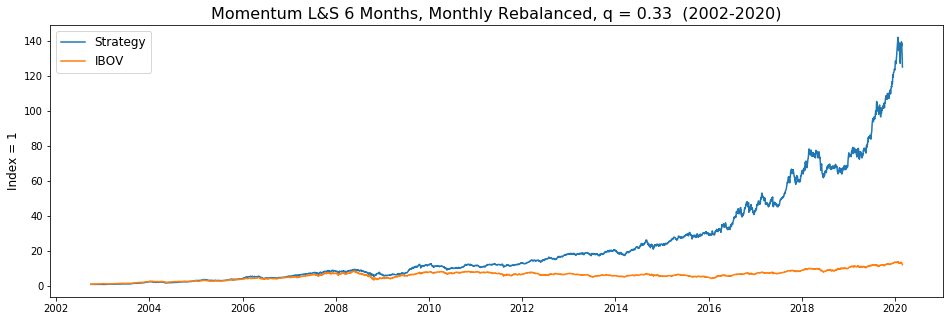

Volatility = 0.2327721168786493 
Sharpe = 1.2799593857088498 
cagr = 0.31085951589465366 
maxdrawdown = -0.4322508885672036


In [906]:
plt.figure(figsize=(16,5))
plt.plot(strategy_daily_performance.loc['2002-09-30':],label='Strategy')
plt.plot(index_daily_performance,label='IBOV')
plt.ylabel('Index = 1',fontsize=12)
plt.title('Momentum L&S 6 Months, Monthly Rebalanced, q = '+str(q)+ '  (2002-2020)',fontsize=16)
plt.legend(loc='upper left',fontsize=12)
plt.show()

volatility = strategy_daily_returns.std()*252**0.5
sharpe = 252**0.5*(strategy_daily_returns.mean()/strategy_daily_returns.std())
cagr = (strategy_daily_performance.iloc[-1]/strategy_daily_performance.iloc[0])**(252/len(strategy_daily_performance))-1
max_drawdown = min(strategy_daily_performance/strategy_daily_performance.cummax()-1)
print('Volatility = '+str(volatility),
       '\nSharpe = '+str(sharpe),
        '\ncagr = '+str(cagr),
         '\nmaxdrawdown = '+str(max_drawdown))

# Ploto os resultados de 2010-2020:

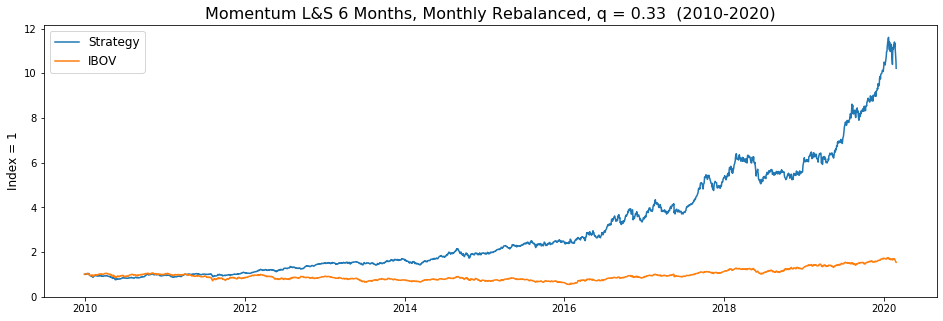

In [907]:
plt.figure(figsize=(16,5))
plt.plot(strategy_daily_performance.loc['2009-12-30':]/strategy_daily_performance.loc['2009-12-30'],label='Strategy')
plt.plot(index_daily_performance.loc['2009-12-30':]/index_daily_performance.loc['2009-12-30'],label='IBOV')
plt.ylabel('Index = 1',fontsize=12)
plt.title('Momentum L&S '+ str(k)+ ' Months, Monthly Rebalanced, q = '+str(q)+ '  (2010-2020)',fontsize=16)
plt.legend(loc='upper left',fontsize=12)
plt.show()

# Ploto os resultados de 2002-2010:

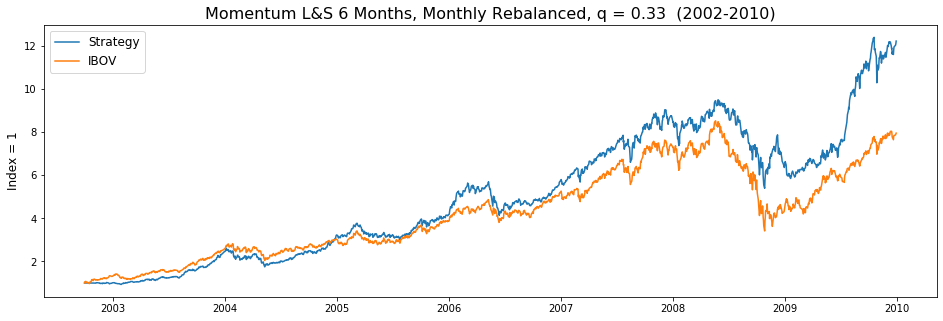

In [908]:
plt.figure(figsize=(16,5))
plt.plot(strategy_daily_performance.loc['2002-09-30':'2009-12-30'],label='Strategy')
plt.plot(index_daily_performance.loc['2002-09-30':'2009-12-30'],label='IBOV')
plt.ylabel('Index = 1',fontsize=12)
plt.title('Momentum L&S '+ str(k)+ ' Months, Monthly Rebalanced, q = '+str(q)+ '  (2002-2010)',fontsize=16)
plt.legend(loc='upper left',fontsize=12)
plt.show()

# Monto um dataframe com todos os retornos anuais:

In [909]:
strategy_yearly_returns = (strategy_daily_performance.resample('Y',kind='period').last().pct_change()*100).to_frame()
strategy_yearly_returns = strategy_yearly_returns.rename(columns={0:'Strategy'})
strategy_yearly_returns.loc['2002']=(strategy_daily_performance.loc['2002-12-30']-1)*100
display(strategy_yearly_returns)

,Strategy
2002,0.504825
2003,144.198037
2004,31.446346
2005,28.582557
2006,36.903072
2007,54.229595
2008,-27.386421
2009,92.251670
2010,-3.298910
2011,12.397292


# Ploto os retornos diários da estratégia: 

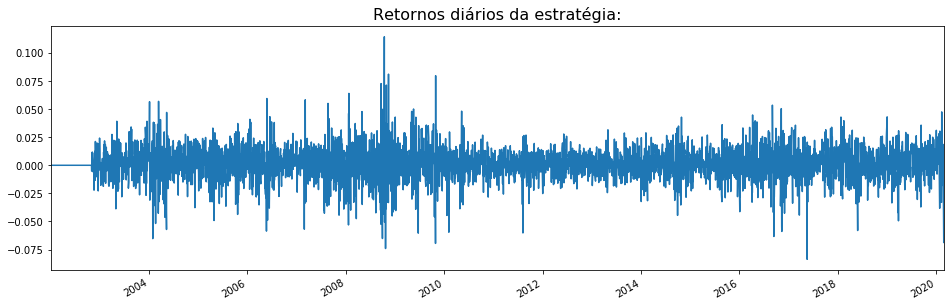

Mínimo = -0.08370119976453079


In [910]:
strategy_daily_returns.plot(figsize=(16,5))
plt.title('Retornos diários da estratégia:',fontsize=16)
plt.show()
print('Mínimo = '+str(strategy_daily_returns.min()))

# Ploto os retornos em janelas de 252 dias: 

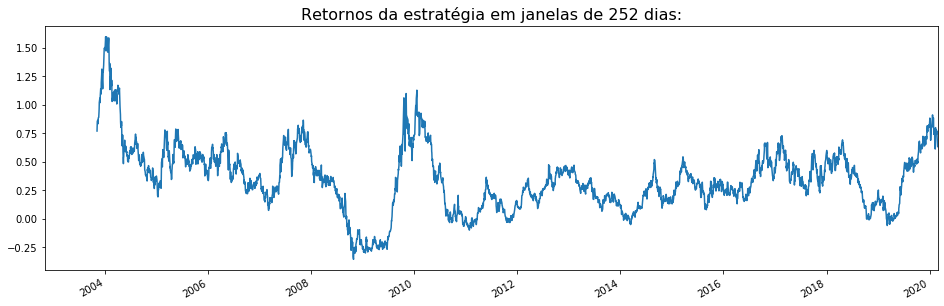

Mínimo = -0.35585837529324615


In [911]:
(strategy_daily_performance['2002-10-31':]/strategy_daily_performance['2002-10-31':].shift(252)-1).plot(figsize=(16,5))
plt.title('Retornos da estratégia em janelas de 252 dias:',fontsize=16)
plt.show()
print('Mínimo = '+str((strategy_daily_performance['2002-10-31':]/strategy_daily_performance['2002-10-31':].shift(252)-1).min()))

# Ploto os retornos em janelas de 756 dias: 

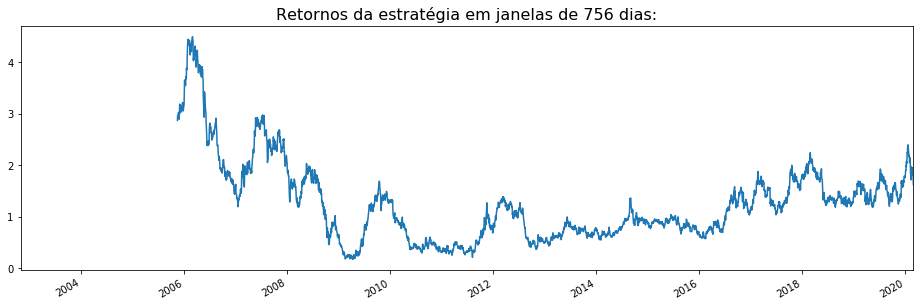

Mínimo = 0.17610295218490468


In [912]:
(strategy_daily_performance['2002-10-31':]/strategy_daily_performance['2002-10-31':].shift(756)-1).plot(figsize=(16,5))
plt.title('Retornos da estratégia em janelas de 756 dias:',fontsize=16)
plt.show()
print('Mínimo = '+str((strategy_daily_performance['2002-10-31':]/strategy_daily_performance['2002-10-31':].shift(756)-1).min()))

# Ploto os retornos em janelas de 1260 dias: 

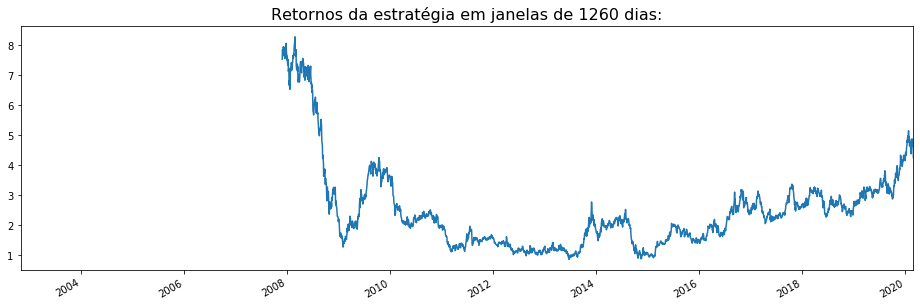

Mínimo = 0.8572814689163912


In [913]:
(strategy_daily_performance['2002-10-31':]/strategy_daily_performance['2002-10-31':].shift(1260)-1).plot(figsize=(16,5))
plt.title('Retornos da estratégia em janelas de 1260 dias:',fontsize=16)
plt.show()
print('Mínimo = '+str((strategy_daily_performance['2002-10-31':]/strategy_daily_performance['2002-10-31':].shift(1260)-1).min()))

# Ploto os retornos em janelas de 2520 dias: 

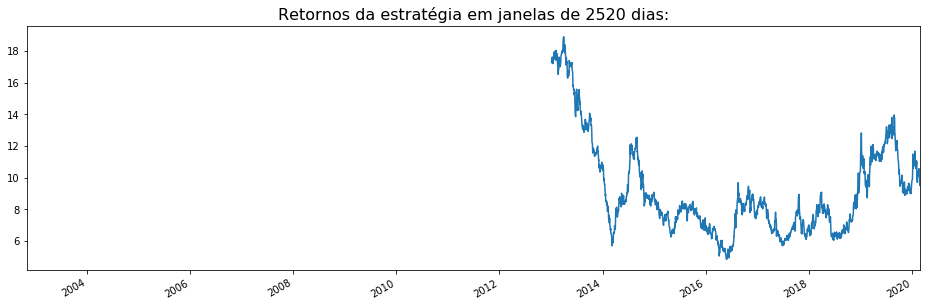

Mínimo = 4.834560593075667


In [914]:
(strategy_daily_performance['2002-10-31':]/strategy_daily_performance['2002-10-31':].shift(2520)-1).plot(figsize=(16,5))
plt.title('Retornos da estratégia em janelas de 2520 dias:',fontsize=16)
plt.show()
print('Mínimo = '+str((strategy_daily_performance['2002-10-31':]/strategy_daily_performance['2002-10-31':].shift(2520)-1).min()))

# Ploto a volatilidade móvel de 252 dias:

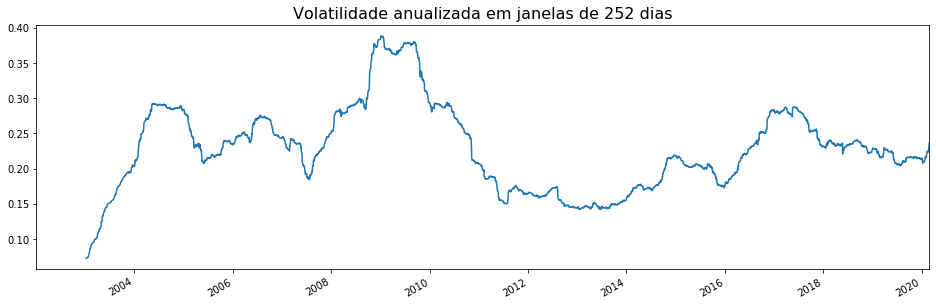

In [915]:
(strategy_daily_returns.rolling(window=252).std()*252**0.5).plot(figsize=(16,5))
plt.title('Volatilidade anualizada em janelas de 252 dias',fontsize=16)
plt.show()

# Ploto o Underwater da Estratégia:

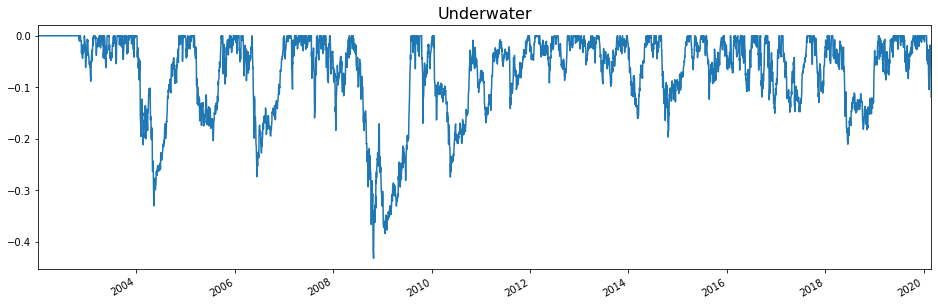

In [916]:
(strategy_daily_performance/strategy_daily_performance.cummax()-1).plot(figsize=(16,5))
plt.title('Underwater',fontsize=16)
plt.show()